# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from msresist.parameter_tuning import kmeansPLSR_tuning
from msresist.figures.figure2 import plotR2YQ2Y, plotKmeansPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnKMEANS
from msresist.sequence_analysis import preprocess_seqs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)

ABC = preprocessing(AXLwt=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")


header = ABC.columns
treatments = ABC.columns[7:]

data = ABC.iloc[:, 7:].T

### Phenotypes

#### Cell Viability:

In [3]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

## 1. Cross-validation

### 1.1 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

In [4]:
ncl = 2

In [5]:
kmeans = MyOwnKMEANS(ncl).fit(data, Y_cv)
centers = kmeans.transform(data)

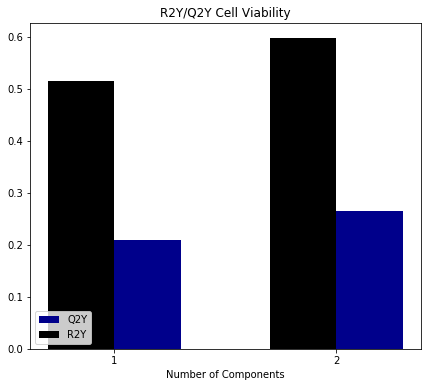

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

### 1.2 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

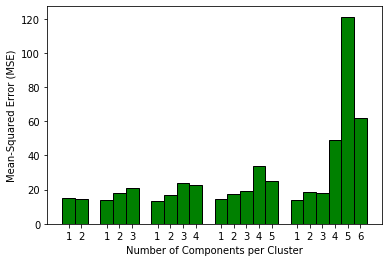

In [7]:
fig, ax = plt.subplots(1, 1)
plotKmeansPLSR_GridSearch(ax, data, Y_cv)

## 2. Model Predicted vs Actual for best Hyperparameter Set

In [8]:
ncomp = 2

### 2.1 With CV Strategy 1:

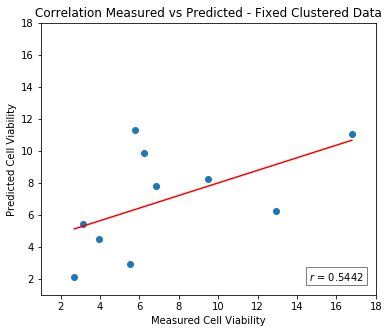

In [9]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

plotMeasuredVsPredicted(ax, PLSRegression(ncomp), centers, Y_cv)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data");

### 2.2 With CV Strategy 2:

In [10]:
estimators = [('kmeans', MyOwnKMEANS(ncl)), ('plsr', PLSRegression(ncomp))]
kmeans_plsr = Pipeline(estimators)
fit = kmeans_plsr.fit(data, Y_cv)

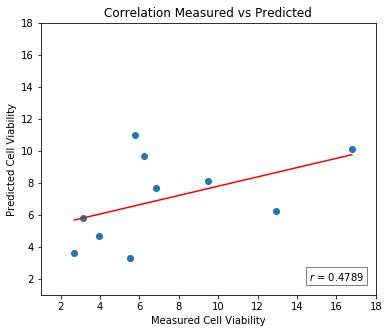

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, kmeans_plsr, data, Y_cv)

## 3. PLSR scores and loadings 

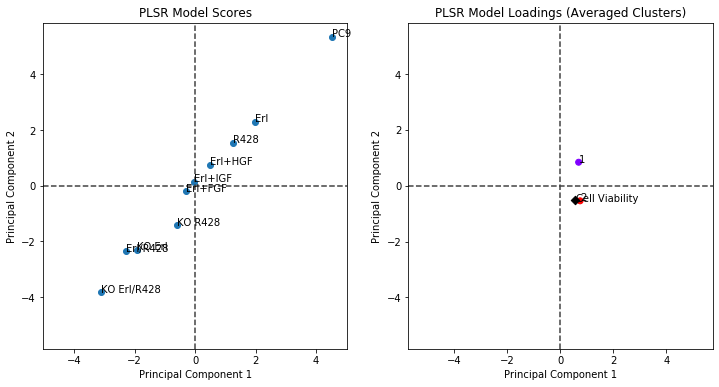

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
colors_ = cm.rainbow(np.linspace(0, 1, ncl))

# plotScoresLoadings(ax, kmeans_plsr, data, Y_cv, ncl, colors_)
plotScoresLoadings(ax, fit, centers, Y_cv, ncl, treatments)

In [13]:
clustermembers = kmeans_plsr.named_steps.kmeans.clustermembers(ABC.T)
clustermembers

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,UniprotAcc_C2,Pos_C2,r2/Std_C2,BioReps_C2
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",Y783-p,RNPGFyVEANP,P19174,PLCG1,1,N/A,14-3-3 protein epsilon,Y131-p,GDYHRyLAEFA,P62258,YWHAE,1,N/A
1,60S ribosomal protein L22-like 1,Y108-p,TYELRyFQISQ,Q6P5R6,RPL22L1,1,N/A,14-3-3 protein zeta/delta,Y48-p,LLSVAyKNVVG,P63104,YWHAZ,1,N/A
2,ADP-ribosylation factor-like protein 11,Y30-p,KtTLLyKLKGH,Q969Q4,ARL11,2,0.94,ARF GTPase-activating protein GIT1,Y383-p,DDQHDyDSVAS,Q9Y2X7,GIT1,1,N/A
3,ADP/ATP translocase 2,Y81-p,ANVIRyFPTQA,P05141,SLC25A5,1,N/A,ATPase WRNIP1,Y500-p,AGEEHyNCISA,Q96S55,WRNIP1,1,N/A
4,ARF GTPase-activating protein GIT1,Y598-p,GADSDyENTQS,Q9Y2X7,GIT1,1,N/A,Actin filament-associated protein 1-like 2,Y56-p,DEEYIyMNKVT,Q8N4X5,AFAP1L2,1,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Tyrosine-protein kinase Yes,Y336-p,KLVPLyAVVSE,P07947,YES1,1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,Tyrosine-protein kinase receptor UFO,Y759-p,ENSEIyDYLRQ,P30530,AXL,1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,Vasodilator-stimulated phosphoprotein,Y39-p,SRVQIyHNPTA,P50552,VASP,2,0.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,Vigilin,Y437-p,INRMDyVEINI,Q00341,HDLBP,1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Cluster Averages across Conditions

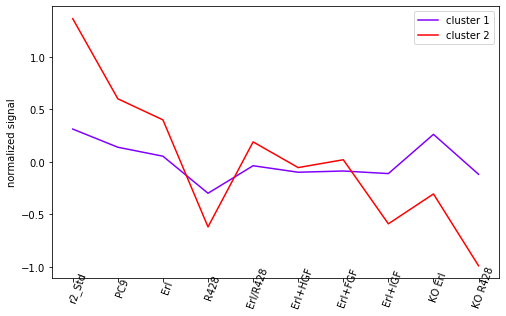

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, ABC, kmeans_plsr, ncl, mixed=False)